# Artificial Neural Networks

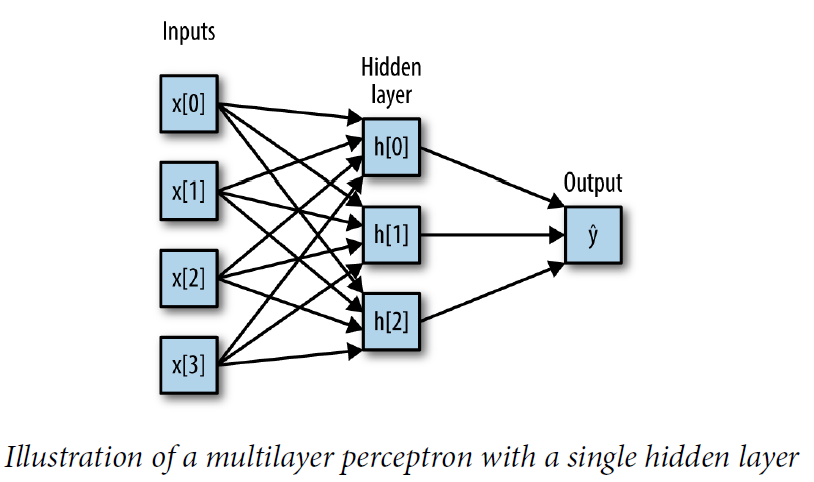

In [13]:
from IPython.display import Image
Image(filename='Image2.png',width = "600",height = "300")

1. Here, each node on the left represents an input feature, the connecting lines represent
the learned coefficients, and the node on the right represents the output, which is a
weighted sum of the inputs.

2. This model has a lot more coefficients (also called weights) to learn: there is one
between every input and every hidden unit (which make up the hidden layer), and
one between every unit in the hidden layer and the output.

3. Computing a series of weighted sums is mathematically the same as computing just
one weighted sum, so to make this model truly more powerful than a linear model,
we need one extra trick. After computing a weighted sum for each hidden unit, a
nonlinear function is applied to the result—usually the rectifying nonlinearity (also
known as rectified linear unit or relu) or the tangens hyperbolicus (tanh). The result of
this function is then used in the weighted sum that computes the output, ŷ. The two
functions are visualized in the following Figure. The relu cuts off values below zero, while tanh
saturates to –1 for low input values and +1 for high input values. Either nonlinear
function allows the neural network to learn much more complicated functions than a
linear model could:

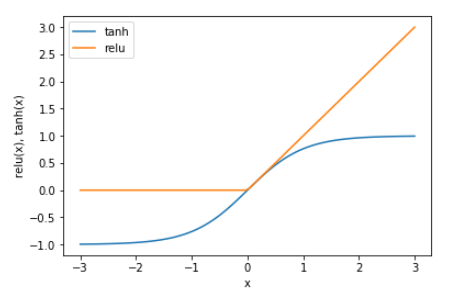

In [3]:
from IPython.display import Image
Image(filename='Image3.png',width = "400",height = "300")

For the small neural network pictured in the first figure, the full formula for computing ŷ in the case of regression would be (when using a tanh nonlinearity):   
h[0] = tanh(w[0, 0] * x[0] + w[1, 0] * x[1] + w[2, 0] * x[2] + w[3, 0] * x[3] + b[0])   
h[1] = tanh(w[0, 1] * x[0] + w[1, 1] * x[1] + w[2, 1] * x[2] + w[3, 1] * x[3] + b[1])   
h[2] = tanh(w[0, 2] * x[0] + w[1, 2] * x[1] + w[2, 2] * x[2] + w[3, 2] * x[3] + b[2])   
ŷ = v[0] * h[0] + v[1] * h[1] + v[2] * h[2] + b

Here, **w** are the weights between the input **x** and the hidden layer **h**, and **v** are the
weights between the hidden layer **h** and the output ŷ. The weights **v** and **w** are learned
from data, **x** are the input features, ŷ is the computed output, and **h** are intermediate
computations. An important parameter that needs to be set by the user is the number
of nodes in the hidden layer. This can be as small as 10 for very small or simple datasets
and as big as 10,000 for very complex data.

Having large neural networks made up of many of these layers of computation is
what inspired the term “deep learning.”

# Data used here

Here, we use the data **Avila** from UCI: https://archive.ics.uci.edu/ml/datasets/Avila#. The Avila data set has been extracted from 800 images of the 'Avila Bible', an XII century giant Latin copy of the Bible. The prediction task consists in associating each pattern to a copyist. In this lab, the‘avila-tr.txt'data is used. For your convenience, I have pre-processed an 'CSV' file in the Github.

### Data Set Information:

CLASS DISTRIBUTION (training set)

A: 4286 

B: 5 

C: 103 

D: 352 

E: 1095 

F: 1961 

G: 446 

H: 519 

I: 831 

W: 44 

X: 522 

Y: 266

### Attribute Information:

F1: intercolumnar distance 

F2: upper margin 

F3: lower margin 

F4: exploitation 

F5: row number 

F6: modular ratio 

F7: interlinear spacing 

F8: weight 

F9: peak number 

F10: modular ratio/ interlinear spacing 

Class: A, B, C, D, E, F, G, H, I, W, X, Y

### Relevant Papers:

C. DeÂ Stefano, M. Maniaci, F. Fontanella, A. ScottoÂ diÂ Freca, 
Reliable writer identification in medieval manuscripts through page layout features: The 'Avila' Bible case, Engineering Applications of Artificial Intelligence, Volume 72, 2018, pp. 99-110. 

C. De Stefano, F. Fontanella, M. Maniaci and A. Scotto di Freca, 'A Method for Scribe Distinction in Medieval Manuscripts Using Page Layout Features', Lecture Notes in Computer Science, G. Maino and G. Foresti (eds.), Springer-Verlag, vol. 6978, pp. 393-402.

## Import modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [4]:
from joblib._parallel_backends import LokyBackend

class NestedBackend(LokyBackend):
    def get_nested_backend(self):
        backend = NestedBackend()
        backend.nested_level = 0
        return backend, None

from joblib import Parallel, delayed
def print_pid(level=0):
    import os
    import time
    time.sleep(.2)
    print(f"Level {level}: {os.getpid()}")


def nested():
    print_pid(1)
    Parallel(n_jobs=2)(delayed(print_pid)(2) for _ in range(2))


backend = NestedBackend()
    
print_pid() 
Parallel(n_jobs=2, backend=backend)(delayed(nested)() for _ in range(2))

Level 0: 2533


[None, None]

## Load the data

In [5]:
# Load the data and show the basic information
data=pd.read_csv("avila-tr.csv")
print('Data size: (%.f, %.f)\n' % data.shape)
data.head()

Data size: (10430, 11)



,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,Class
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


## Study the Multi-layer Perceptron model and its parameters
We will use the multi-layer percepton to understand the basic usage of artificial neural network models. Class [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. MLPClassifier has many parameters to configure. The effects of some important parameters have been discussed in our lecture, e.g., activation functions, number of hidden layers, number of units in a hidden layer, gradient descent, regularization, etc. So, in this workshop we would like to empirically study these parameters. 

### 1. Basic usage of the model

In [6]:
# Specify features and the target
X = data.drop(['Class'], axis = 'columns')
y = data['Class']

# Split the dataset into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Training the MLPClassifier with the default parameters (random_state=42)
clf = MLPClassifier(random_state=42)
clf.fit(X_train, y_train)

# Output the accuracy on training data and test data respectively
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.4f \n' % accuracy)

Accuracy: 0.7584 



In [7]:
# Explore the learned MLP model
print(clf)
print('\n# of layers (including the input layer): %.f\n' % clf.n_layers_)
print('MLP structure: %.f X %.f X %.f\n' % (X.shape[1], clf.get_params()['hidden_layer_sizes'][0], clf.n_outputs_))

MLPClassifier(random_state=42)

# of layers (including the input layer): 3

MLP structure: 10 X 100 X 12



### 2. Use 10-fold cross validation to report a more robust testing performance

In [8]:
# Use 10-fold cross validation to validate the model
clf = MLPClassifier(random_state=42)
scores_mlp_default = cross_val_score(clf, X, y, cv=10, verbose=1)
print('Accuracy range for Multi-layer Perceptron: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores_mlp_default.min(), scores_mlp_default.max(), scores_mlp_default.mean(), scores_mlp_default.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy range for Multi-layer Perceptron: [0.7574, 0.7862]; mean: 0.7743; std: 0.0082



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   57.1s finished


In [9]:
print("Accuracy of Model with Cross Validation is:",scores_mlp_default.mean() * 100)

Accuracy of Model with Cross Validation is: 77.43048897411315


### 3. Increase the number of hidden units
Here, we draw a figure to report the testing accuray with differnt number of hidden units [10,20,30,40,50,60,70,80,90,100]. The parameter 'hidden_layer_sizes' accepts a list of numbers specifying the number of units in each hidden layer. We plot the relationship between the parameter and the accuracy score.

In [10]:
# For each number of hidden units, we use 10-fold cross validation to report the testing accuracy.
# N.B.: The execution time is relatively long. This is to let you experience the intenstive computaiton required by artificial neural network models.
cv_scores = []
cv_scores_std = []
hidden_unit_numbers = [[10],[20],[30],[40],[50],[60],[70],[80],[90],[100]]
for i in hidden_unit_numbers:
    clf_mlp = MLPClassifier(hidden_layer_sizes=i, random_state=42)
    scores = cross_val_score(clf_mlp, X, y, scoring='accuracy', cv=10, verbose=1)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   51.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   47.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   48.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   50.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

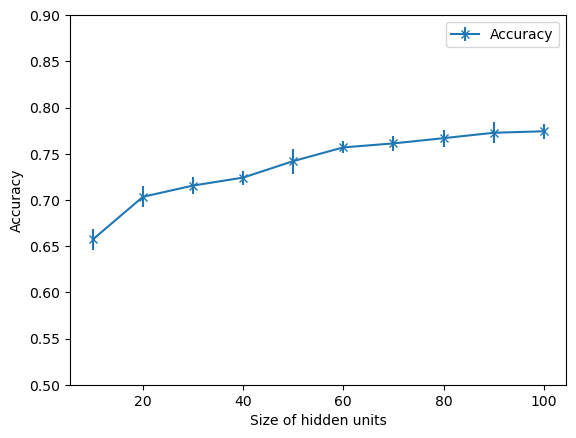

In [11]:
# Plot the relationship
plt.errorbar(hidden_unit_numbers, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Size of hidden units')
plt.ylim(0.5, 0.9)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**It can be seen that the accuracy increases when the number of units in the hidden layer increases. The reason is the a model with a bigger number of hiden layer units has a higher complexity to capture the information in data.**

### Task1. Number of hidder layers
Set the number of hidden layers as two, and each has 100 units. Please report the accuracy score and compare it with the single hidden layer case mentioend above. Note that the execution time for this task is relative long. To track the progress of the execution, you could set the verbose parameter in the cross_val_score method as 'verbose=1'.

In [12]:
# An MLP model with two hidden layers

mlp = MLPClassifier(hidden_layer_sizes=(100,100),random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.4f \n' % accuracy)

Accuracy: 0.8543 



In [13]:
predictions_train = mlp.predict(X_train)
print(accuracy_score(predictions_train, y_train))
predictions_test = mlp.predict(X_test)
print(accuracy_score(predictions_test, y_test))

0.9324750034241884
0.8542665388302972


In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),random_state=42)
scores_mlp = cross_val_score(mlp, X, y, cv=10, verbose=1)
print('Accuracy range for Multi-layer Perceptron: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores_mlp.min(), scores_mlp.max(), scores_mlp.mean(), scores_mlp.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy range for Multi-layer Perceptron: [0.8715, 0.8984]; mean: 0.8805; std: 0.0081



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [15]:
print("Accuracy of Model with Cross Validation is:",scores_mlp.mean() * 100)

Accuracy of Model with Cross Validation is: 88.05369127516778


The accuracy of the Multi-layer Perceptron model with two hidden layers is higher than the single hidden layer case  model mentioend above

### 4. Choose solver for the learning process
As discussed in our lecture, we can use gradient descent methods (standard gradient and stochastic gradient descent) to learn weights for the error minimization problem. Moreover, we can have other solvers for the optimization problem. Here, we draw a figure to report the accuray with differnt solvers. The parameter 'solver' can take values from ['lbfgs','sgd', 'adam']. 'sgd' represents stochastic gradient descent.

In [16]:
# Try different solvers
cv_scores = []
cv_scores_std = []
solvers = ['lbfgs', 'sgd', 'adam']
for i in solvers:
    clf_mlp = MLPClassifier(solver=i, random_state=42)
    scores = cross_val_score(clf_mlp, X, y, scoring='accuracy', cv=10)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

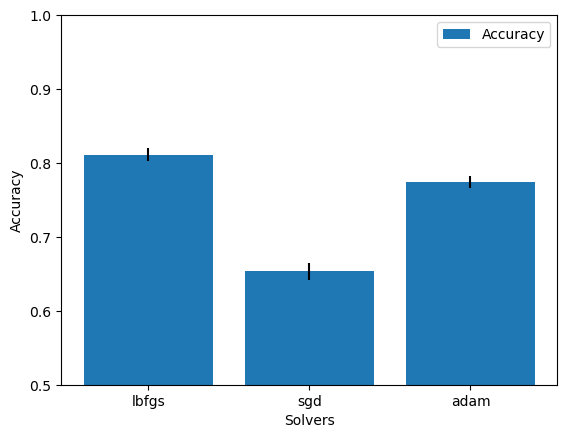

In [17]:
# Plot the relationship
plt.bar(solvers, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Solvers')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**It can be seen that sgd doesn't perform as well as the other two solvers**

### Task2. Activation functions
It can be seen above that the default activation function is 'ReLU'. As we discussed in our lecture, we could have different types of activation functions. Please try the possible functions 'identity’, ‘logistic’, ‘tanh’, and ‘relu’ provided by the API. Draw a figure to report the accuray with differnt activation functions.

In [18]:
# Try different activation functions
cv_scores = []
cv_scores_std = []
Activation_Functions = ['identity','logistic','tanh','relu']
for i in Activation_Functions:
    clf_mlp = MLPClassifier(activation=i, random_state=42)
    scores = cross_val_score(clf_mlp, X, y, scoring='accuracy', cv=10)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())                       

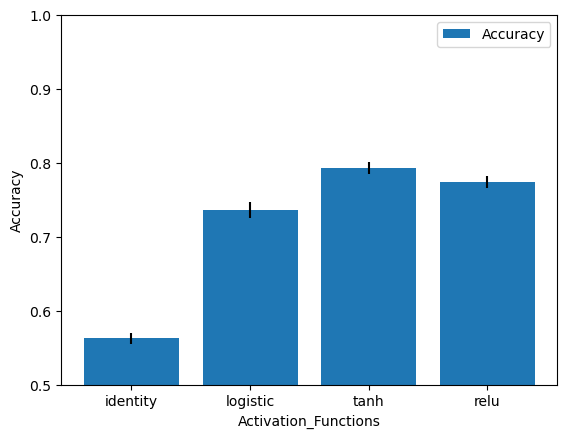

In [20]:
# Plot the relationship
plt.bar(Activation_Functions, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Activation_Functions')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

<b>‘tanh activation function’</b>, the hyperbolic tan function, returns f(x) = tanh(x) provides the model with the highest accuracy 

### 5. Use different values of alpha
The parameter alpha is the L2 penalty (regularization term) to overcome the overfitting issue. It balance the error caused the data and that by the model structure (number of weights). 
Here, please draw a figure to report the accuray with differnt values of alpha [0.0001,0.001,0.01, 0.1,1].

In [21]:
# Try different regulaization parameters
cv_scores = []
cv_scores_std = []
alphas = [0.0001,0.001,0.01, 0.1,1]
for i in alphas:
    clf_mlp = MLPClassifier(alpha=i, random_state=42)
    scores = cross_val_score(clf_mlp, X, y, scoring='accuracy', cv=10)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

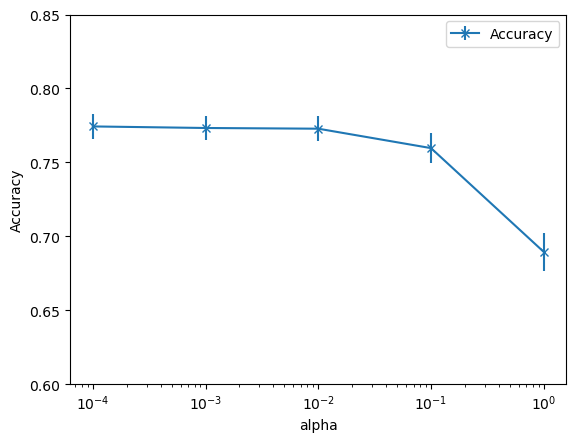

In [22]:
# Plot the relationship
plt.errorbar(alphas, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylim([0.6, 0.85])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**It can be seen that when alpha increases, the prediction accuracy drops, showing that the overfitting issue of the model on this dataset is not a big problem.**

### Task3. Increase the number of iterations
This is related to the early stopping technique we mentioned in the lecture. Please explore when is good enough to stop the iteration of weight updating. Please draw a figure to report the accuray with differnt number of iterations [200,400,600,800,1000]. The parameter 'max_iter' can specify this setting. Note that the execution time for this task is relative long. To track the progress of the execution, you could set the verbose parameter in the cross_val_score method as 'verbose=1'.

In [23]:
# Try different number of iterations. Plot the relationship between the performance and the number of iterations.
cv_scores = []
cv_scores_std = []
max_iters = [200,400,600,800,1000]
for i in max_iters:
    clf_mlp = MLPClassifier(max_iter=i, random_state=42)
    scores = cross_val_score(clf_mlp, X, y, scoring='accuracy', cv=10, verbose=1)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.0min finished


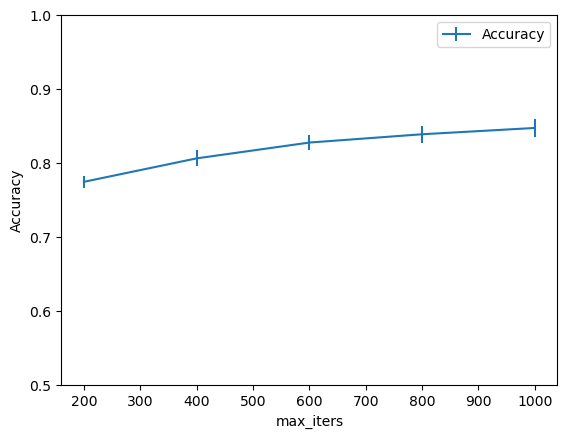

In [26]:
# Plotting the relationship
plt.errorbar(max_iters, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('max_iters')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

As the Maximum number of iterations increases, so does the accuracy of the model.

## Comparing with other classification models
### Task4. Compare the results with Naive Bayes (GaussianNB) and K-Nearest Neighbors (K=1)
Compare their accuracy scores and use t test to show if their perofrmance has siginficantly different with significance level 0.05.

In [28]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")

In [34]:
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)

y_pred = clf_gnb.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: %.4f\n' % accuracy)

Testing accuracy is: 0.2950



In [35]:
clf_gnb = GaussianNB()
clf_gnb_scores = cross_val_score(clf_gnb, X, y, scoring='accuracy', cv=10)
print('Gaussian Naive Bayes accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (clf_gnb_scores.min(), clf_gnb_scores.max(), clf_gnb_scores.mean(), clf_gnb_scores.std()))

Gaussian Naive Bayes accuracy range: [0.2771, 0.3212]; mean: 0.2993; std: 0.0123



In [36]:
print("Accuracy of the GaussianNB Model with Cross Validation is:",clf_gnb_scores.mean() * 100)

Accuracy of the GaussianNB Model with Cross Validation is: 29.93288590604027


In [31]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=1)
clf_knn.fit(X_train, y_train)

y_pred = clf_knn.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('Testing accuracy is: %.4f\n' % accuracy)

Testing accuracy is: 0.7386



In [37]:
clf_knn = KNeighborsClassifier(n_neighbors=1)
clf_knn_scores = cross_val_score(clf_knn, X, y, scoring='accuracy', cv=10)
print('K-Nearest Neighbors (K=1) accuracy range: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (clf_knn_scores.min(), clf_knn_scores.max(), clf_knn_scores.mean(), clf_knn_scores.std()))

K-Nearest Neighbors (K=1) accuracy range: [0.7325, 0.7804]; mean: 0.7517; std: 0.0125



In [38]:
print("Accuracy of the K-Nearest Neighbors (K=1) Model with Cross Validation is:",clf_knn_scores.mean() * 100)

Accuracy of the K-Nearest Neighbors (K=1) Model with Cross Validation is: 75.16778523489933


In [33]:
# This is to show t-test on their performances.
from scipy.stats import ttest_ind
t, p = ttest_ind(clf_gnb_scores, clf_knn_scores)
print ('t, p: %.4f, %.4f\n' % (t, p))

t, p: -77.3593, 0.0000



The average accuracy of the Multi-layer Perceptron model is the highest with 88.05. The K nearest neighbors classifier comes second with 75.17 and the GuassianNB Model has an average accuracy of 29.93. Comparing the GuassianNB Model and the K nearest neighbors model, the two models are significantly different with the value of p < 0.05